In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits
from sklearn.exceptions import NotFittedError
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None, cmap='bwr'):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap=cmap)
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    # your code here
    pass

In [ ]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

TypeError: ignored

### Pipeline Version (2 points)

In [6]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        self.copy=copy
        self.columns=columns
        self.with_mean=with_mean
        self.with_std=with_std


    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns

        if self.with_mean: 
            self.means_ = np.mean(X[self.columns], axis=0)
        else:
            self.means_ = np.zeros(X[self.columns].shape[1])

        if self.with_std: 
            self.stds_ = np.std(X[self.columns], axis=0)
        else:
            self.means_ = np.ones(X[self.columns].shape[1])    

        return self

    def transform(self, X, y=None, copy=None):
        if hasattr(self, 'means_') and hasattr(self, 'stds_'):
            copy = copy if copy is not None else self.copy
            if copy:
                X_copy = X.copy()
                X_copy.loc[:, self.columns] -= self.means_
                X_copy.loc[:, self.columns] /= self.stds_
                return X_copy

            X.loc[:, self.columns] -= self.means_
            X.loc[:, self.columns] /= self.stds_
            return X

        else: 
            raise NotFittedError("CustomScaler instance is not fitted yet")
        
      
    def fit_transform(self, X, y=None, copy=None):
        return self.fit(X).transform(X)

In [7]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

In [8]:
scaled_wine_data = CustomScaler().fit_transform(wine_data)
scaled_wine_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 3.1884165 ,  0.32288013],
       [-7.73706518,  0.38766571],
       [-0.99466645,  1.44228488],
       ...,
       [11.60091848,  4.10107338],
       [ 3.07433961,  5.65950836],
       [-4.23780216,  5.26003831]])

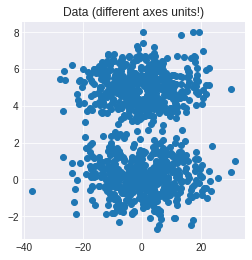

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

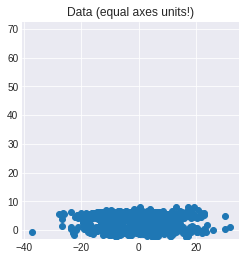

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

In [12]:
min_max_scaler = MinMaxScaler()

min_max_scaled_data = min_max_scaler.fit_transform(data)

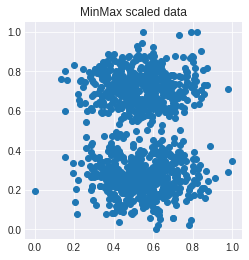

In [13]:
plot_scatter(min_max_scaled_data[:, 0], min_max_scaled_data[:, 1], auto_scaled=False , title='MinMax scaled data')

### StandardScaler (0.5 point)

In [14]:
standard_scaler = StandardScaler()

standard_scaled_data = standard_scaler.fit_transform(data)

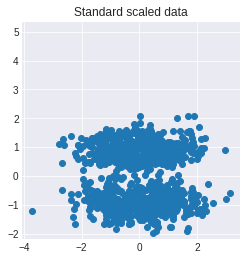

In [15]:
plot_scatter(standard_scaled_data[:, 0], standard_scaled_data[:, 1], auto_scaled=False , title='Standard scaled data')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


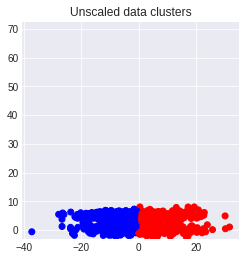

In [16]:
k_means = KMeans(n_clusters=2)
k_means.fit(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Unscaled data clusters', clusters=k_means.labels_)

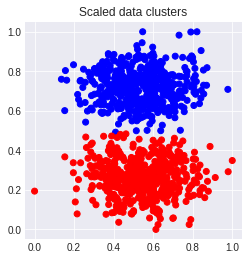

In [17]:
k_means_scaled = KMeans(n_clusters=2)
k_means_scaled.fit(min_max_scaled_data)
plot_scatter(min_max_scaled_data[:, 0], min_max_scaled_data[:, 1], auto_scaled=False , title='Scaled data clusters', clusters=k_means_scaled.labels_)

The clusters are different for scaled and not scaled data. Scaling helped to determine optimal centroids and separate data in more natural way.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [18]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

### Model on raw data

In [19]:
lr = LogisticRegression(solver='liblinear', penalty='l1')
lr.fit(wine_train, wine_labels_train)
wine_pred = lr.predict(wine_val)
accuracy_score(wine_labels_val, wine_pred)

0.9814814814814815

### Model on scaled data

In [20]:
preprocessor = Pipeline([
        ('scaler', StandardScaler())
    ])

wine_train_scaled = preprocessor.fit_transform(wine_train)
wine_val_scaled = preprocessor.transform(wine_val)

lr_scaled = LogisticRegression(solver='liblinear', penalty='l1')
lr_scaled.fit(wine_train_scaled, wine_labels_train)
wine_pred = lr_scaled.predict(wine_val_scaled)
accuracy_score(wine_labels_val, wine_pred)

0.9814814814814815

### Model on scaled data with feature selection:

Let's build correlation matrix

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


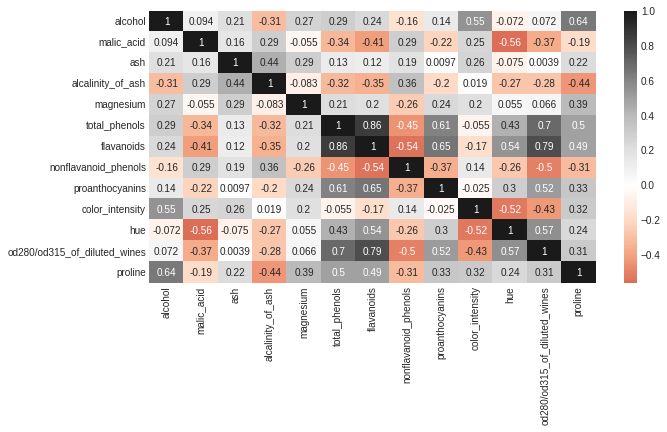

In [21]:
correlation_matrix= wine_data.corr()
display(correlation_matrix)
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix, center=0, annot=True, cmap='RdGy')
plt.show()

We can see that the most correlated features have correlation 0.86.

Let's try to drop every feature and check the accuracy

In [22]:
for c in wine_data.columns:
    selected_features = wine_data.columns.drop([c])

    preprocessor_fs = Pipeline([
            ('scaler', ColumnTransformer(transformers=[('pol_transformer', StandardScaler(), selected_features)]))
    ])

    wine_train_fs = preprocessor_fs.fit_transform(wine_train)
    wine_val_fs = preprocessor_fs.transform(wine_val)

    lr_fs = LogisticRegression(solver='liblinear', penalty='l1')
    lr_fs.fit(wine_train_fs, wine_labels_train)
    wine_pred_fs = lr_fs.predict(wine_val_fs)
    print(f'{c}: {accuracy_score(wine_labels_val, wine_pred_fs)}')

alcohol: 1.0
malic_acid: 0.9814814814814815
ash: 1.0
alcalinity_of_ash: 1.0
magnesium: 0.9814814814814815
total_phenols: 0.9814814814814815
flavanoids: 0.9814814814814815
nonflavanoid_phenols: 0.9814814814814815
proanthocyanins: 0.9814814814814815
color_intensity: 0.9629629629629629
hue: 1.0
od280/od315_of_diluted_wines: 0.9814814814814815
proline: 0.9814814814814815


Removing alcohol, ash, alcalinity_of_ash or hue have increased accuracy to 1. Let's try to remove them all and check the accuracy



In [23]:
selected_features = wine_data.columns.drop(['alcohol', 'ash', 'alcalinity_of_ash', 'hue'])

preprocessor_fs = Pipeline([
        ('scaler', ColumnTransformer(transformers=[('pol_transformer', StandardScaler(), selected_features)]))
])

wine_train_fs = preprocessor_fs.fit_transform(wine_train)
wine_val_fs = preprocessor_fs.transform(wine_val)

lr_fs = LogisticRegression(solver='liblinear', penalty='l1')
lr_fs.fit(wine_train_fs, wine_labels_train)
wine_pred_fs = lr_fs.predict(wine_val_fs)
accuracy_score(wine_labels_val, wine_pred_fs)

1.0

Let's compare the coeficients of raw data model and scaled data model.

In [24]:
lr.coef_

array([[-2.26157836e-01,  3.54929257e-01,  3.46763041e-01,
        -5.17391292e-01, -4.39132939e-02,  0.00000000e+00,
         2.14897437e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.36337578e-02],
       [ 8.30494833e-01, -9.47113030e-01,  0.00000000e+00,
         2.40259031e-01,  3.62937408e-03,  0.00000000e+00,
         4.36307639e-01,  0.00000000e+00,  8.19743964e-01,
        -1.95670970e+00,  0.00000000e+00,  5.69162475e-02,
        -1.14473771e-02],
       [ 0.00000000e+00,  2.69209493e-01,  0.00000000e+00,
         5.16561940e-02,  7.73448325e-03,  0.00000000e+00,
        -2.81328085e+00,  0.00000000e+00,  0.00000000e+00,
         9.34177973e-01,  0.00000000e+00, -1.68558675e+00,
        -5.49810062e-04]])

In [25]:
lr_scaled.coef_

array([[ 1.41794578,  0.        ,  0.9674324 , -1.58497583,  0.        ,
         0.        ,  1.01434556,  0.        ,  0.        ,  0.        ,
         0.        ,  0.80771871,  1.8926826 ],
       [-1.87679996, -0.09677889, -1.28095723,  0.82045589,  0.        ,
         0.        ,  0.26194564,  0.        ,  0.45342943, -1.52734393,
         1.60370511,  0.        , -2.01350303],
       [ 0.        ,  0.10367446,  0.40485052,  0.        ,  0.        ,
         0.        , -1.89198138,  0.        , -0.17594778,  1.59104936,
        -1.28200491, -0.64212371,  0.        ]])

In [26]:
wine_data.describe().loc[['min', 'max'], :]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
min,11.03,0.74,1.36,10.6,70.0,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.0
max,14.83,5.80,3.23,30.0,162.0,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.0


As we can see the weights of the model on raw data differ from weights of the model with scaled data. Despite the models have the same accuracy it may cause issues with applying raw data model on other data as model biased due to different scales of features. Also we can observe that applying feature selection to the scaled data improved model acccuracy to 1. So we used less features and improved the score which is amazing!

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [27]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [28]:
scaler = StandardScaler()
scaled_wine_data = scaler.fit_transform(wine_data)

S = scaled_wine_data.T @ scaled_wine_data / (scaled_wine_data.shape[0] - 1)

If your code is correct, the following assert should be Ok.

In [29]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [30]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return -(x @ S @ x.T)

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return np.linalg.norm(x) - 1

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(wine_data.shape[1])

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [31]:
def orthogonality_constraint(x):
    return x @ x0.T
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(wine_data.shape[1])


sol = minimize(objective, 
               x1, 
               constraints = ({'type': 'eq', 'fun': orthogonality_constraint},
                              {'type': 'eq', 'fun': norm_constraint})
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [32]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

In [33]:
pc1 = x0 @ scaled_wine_data.T
pc2 = x1 @ scaled_wine_data.T

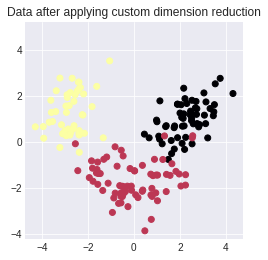

In [34]:
plot_scatter(pc1, pc2, auto_scaled=False, title='Data after applying custom dimension reduction', clusters=wine_labels, cmap='inferno')

We can see that the points are well grouped after applying custom dimension reduction.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [35]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

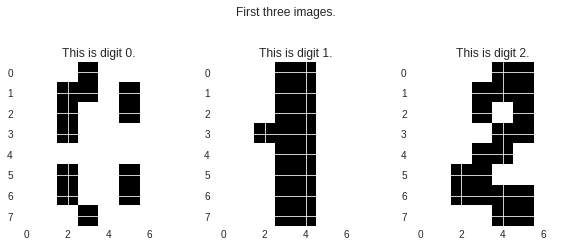

In [36]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [39]:
clf = RandomForestClassifier(max_depth=13, random_state=41)

# your code here
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(acc)

0.9814814814814815


In [40]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [42]:
#! pip install boruta

In [43]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X), np.array(y))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=63,
                                          random_state=RandomState(MT19937) at 0x7FE665B1C380),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FE665B1C380)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

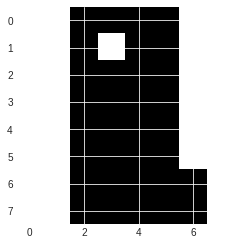

In [44]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

In [45]:
np.sum(feat_selector.support_)

33

At the end let us redo  classification but only with selected features

In [46]:
clf = RandomForestClassifier(max_depth=13, random_state=41)

clf.fit(X_train.loc[:,feat_selector.support_], y_train)

y_pred = clf.predict(X_val.loc[:,feat_selector.support_])

acc = accuracy_score(y_val, y_pred)
print(acc)

0.9938271604938271


In [47]:
assert acc > 0.99

So we have removed 31 features out of 64 and our accuracy is close to the initial model (and even slighttly better in this case). BAM!

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market